In [1]:
from datetime import datetime

import time
import os
import sys
from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
from astropy.io import fits
from astropy.time import Time
import astropy.units as u

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

print(tf.__version__)

1.13.1


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# load data and make some subsets for each wfs for inspection later

data = pd.read_csv("../test_data/2019_wfs.csv")
data['ut'] = pd.to_datetime(data.ut)
data['az'][data['az'] < 0.] += 360.

f9 = data[data['wfs'] == 'newf9']
f5 = data[data['wfs'] == 'f5']
mmirs = data[data['wfs'] == 'mmirs']
bino = data[data['wfs'] == 'binospec']

/Users/tim/conda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [8]:
f5['az'].min()

0.2

In [9]:
data.columns

Index(['ut', 'airmass', 'az', 'cc_x_err', 'cc_y_err', 'chamt', 'el', 'exptime',
       'file', 'focerr', 'focus', 'fwhm', 'osst', 'outt', 'raw_seeing',
       'residual_rms', 'seeing', 'tiltx', 'tilty', 'time', 'transx', 'transy',
       'wavefront_rms', 'wfs', 'xcen', 'ycen', 'comaerr'],
      dtype='object')

In [10]:
# wrangle the times to add colums for mjd to look for trends over time and hour to look for nightly trends
raw_times = data['time']
times = Time(raw_times.values.tolist(), format='isot', scale='utc')
mjd = times.mjd
data['mjd'] = mjd.tolist()
data['hour'] = data['ut'].dt.hour
data.head()

,ut,airmass,az,cc_x_err,cc_y_err,chamt,el,exptime,file,focerr,...,time,transx,transy,wavefront_rms,wfs,xcen,ycen,comaerr,mjd,hour
0,2019-01-07 08:52:20.109,1.0329,11.005093,-0.000,0.000,0.762,75.489591,30.0,f9wfs_20190107-015252.fits,0.00,...,2019-01-07T08:52:20.109000,660.87,1027.74,692.108567,newf9,369.464652,449.093992,0.000000,58490.369677,8
1,2019-01-07 08:53:46.527,1.0327,10.026086,0.000,0.000,0.757,75.543728,30.0,f9wfs_20190107-015418.fits,-6.04,...,2019-01-07T08:53:46.527000,661.93,1026.70,487.315068,newf9,378.922652,444.197907,0.000000,58490.370677,8
2,2019-01-10 06:37:44.616,1.7190,283.541748,-0.000,-0.242,7.682,35.572431,30.0,f9wfs_20190109-233812.fits,7.66,...,2019-01-10T06:37:44.616000,149.41,1633.39,363.252097,newf9,413.161213,441.833007,0.242000,58493.276211,6
3,2019-01-10 07:24:51.145,1.6684,262.283493,0.000,-2.982,7.100,36.824057,30.0,f9wfs_20190110-002520.fits,2.61,...,2019-01-10T07:24:51.145000,403.54,1422.66,471.326820,newf9,400.016602,454.685450,2.982000,58493.308925,7
4,2019-01-11 06:22:35.246,1.2322,310.203323,3.395,1.458,0.658,54.247805,30.0,f9wfs_20190110-232302.fits,-3.82,...,2019-01-11T06:22:35.246000,206.12,1545.03,605.365100,newf9,407.925506,437.723447,3.694833,58494.265686,6


In [34]:
# trim out columns not relevant to training
trimmed = data.drop(columns=['ut', 'time', 'airmass', 'cc_x_err', 'cc_y_err', 'exptime', 'file', 'focerr', 'fwhm', 'raw_seeing', 'residual_rms', 'seeing', 'wavefront_rms', 'xcen', 'ycen', 'comaerr'])

In [35]:
labels = ['focus', 'tiltx', 'tilty', 'transx', 'transy']

# assign columns for each wfs so we can use them as features for training
wfs = trimmed.pop('wfs')
trimmed['f9'] = (wfs == 'newf9') * 1
trimmed['f5'] = (wfs == 'f5') * 1
trimmed['mmirs'] = (wfs == 'mmirs') * 1
trimmed['bino'] = (wfs == 'binospec') * 1
trimmed

,az,chamt,el,focus,osst,outt,tiltx,tilty,transx,transy,mjd,hour,f9,f5,mmirs,bino
0,11.005093,0.762,75.489591,1069.21,3.70,0.8,209.61,81.65,660.87,1027.74,58490.369677,8,1,0,0,0
1,10.026086,0.757,75.543728,1117.59,3.53,0.8,209.55,81.45,661.93,1026.70,58490.370677,8,1,0,0,0
2,283.541748,7.682,35.572431,300.51,10.20,7.3,257.64,171.82,149.41,1633.39,58493.276211,6,1,0,0,0
3,262.283493,7.100,36.824057,531.36,8.85,6.6,241.41,152.30,403.54,1422.66,58493.308925,7,1,0,0,0
4,310.203323,0.658,54.247805,392.71,4.70,1.0,263.71,142.77,206.12,1545.03,58494.265686,6,1,0,0,0
5,217.249859,0.909,55.256390,1208.70,1.02,1.4,248.64,117.48,538.81,1342.69,58494.339418,8,1,0,0,0
6,98.613086,1.138,77.634575,1301.08,0.82,1.5,214.77,85.30,648.72,870.49,58494.398441,9,1,0,0,0
7,60.113495,1.384,80.221469,1399.46,0.90,1.2,224.39,78.69,695.02,991.74,58494.422679,10,1,0,0,0
8,156.085442,0.053,60.188801,1412.41,0.28,0.4,264.32,114.21,519.48,1565.18,58494.468360,11,1,0,0,0
9,32.607925,0.075,79.876987,1485.28,0.20,0.2,193.71,66.91,834.28,906.10,58494.486702,11,1,0,0,0


In [36]:
# the large range in offsets is messing up the training. so normalize the hexapod coords to their means
means = {}
for w in ['f5', 'f9', 'mmirs', 'bino']:
    means[w] = {}
for l in labels:
    # f/5 and bino are optically the same and have very similar mean hexapod coords
    means['f5'][l] = trimmed[(trimmed['f5'] == 1) | (trimmed['bino'] == 1)][l].mean()
    means['bino'][l] = means['f5'][l]
    means['mmirs'][l] = trimmed[trimmed['mmirs'] == 1][l].mean()
    means['f9'][l] = trimmed[trimmed['f9'] == 1][l].mean()

for k in means:
    for l in labels:
        trimmed[l][trimmed[k] == 1] -= means[k][l]
trimmed

/Users/tim/conda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,az,chamt,el,focus,osst,outt,tiltx,tilty,transx,transy,mjd,hour,f9,f5,mmirs,bino
0,11.005093,0.762,75.489591,211.469818,3.70,0.8,-10.681273,-60.049455,390.422727,-244.719818,58490.369677,8,1,0,0,0
1,10.026086,0.757,75.543728,259.849818,3.53,0.8,-10.741273,-60.249455,391.482727,-245.759818,58490.370677,8,1,0,0,0
2,283.541748,7.682,35.572431,-557.230182,10.20,7.3,37.348727,30.120545,-121.037273,360.930182,58493.276211,6,1,0,0,0
3,262.283493,7.100,36.824057,-326.380182,8.85,6.6,21.118727,10.600545,133.092727,150.200182,58493.308925,7,1,0,0,0
4,310.203323,0.658,54.247805,-465.030182,4.70,1.0,43.418727,1.070545,-64.327273,272.570182,58494.265686,6,1,0,0,0
5,217.249859,0.909,55.256390,350.959818,1.02,1.4,28.348727,-24.219455,268.362727,70.230182,58494.339418,8,1,0,0,0
6,98.613086,1.138,77.634575,443.339818,0.82,1.5,-5.521273,-56.399455,378.272727,-401.969818,58494.398441,9,1,0,0,0
7,60.113495,1.384,80.221469,541.719818,0.90,1.2,4.098727,-63.009455,424.572727,-280.719818,58494.422679,10,1,0,0,0
8,156.085442,0.053,60.188801,554.669818,0.28,0.4,44.028727,-27.489455,249.032727,292.720182,58494.468360,11,1,0,0,0
9,32.607925,0.075,79.876987,627.539818,0.20,0.2,-26.581273,-74.789455,563.832727,-366.359818,58494.486702,11,1,0,0,0


In [37]:
train_dataset = trimmed.sample(frac=0.8, random_state=0)
test_dataset = trimmed.drop(train_dataset.index)

train_stats = train_dataset.describe()
train_stats = train_stats.drop(columns=labels)
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
az,5643.0,193.663207,114.727689,0.065961,95.174252,191.194366,307.035377,373.046695
chamt,5643.0,4.876816,3.132168,-6.230000,2.086500,5.193000,7.093500,14.200000
el,5643.0,57.844113,11.160818,26.619272,51.007144,57.304042,63.776416,89.380000
osst,5643.0,4.897111,3.188202,-3.750000,1.500000,5.380000,7.300000,13.500000
outt,5643.0,5.244639,3.072589,-7.000000,2.700000,5.600000,7.300000,14.500000
mjd,5643.0,58549.483299,28.963657,58490.370677,58522.537756,58570.460965,58573.381926,58612.390602
hour,5643.0,6.907673,3.162135,1.000000,4.000000,7.000000,10.000000,13.000000
f9,5643.0,0.007443,0.085958,0.000000,0.000000,0.000000,0.000000,1.000000
f5,5643.0,0.052100,0.222248,0.000000,0.000000,0.000000,0.000000,1.000000
mmirs,5643.0,0.097111,0.296136,0.000000,0.000000,0.000000,0.000000,1.000000


In [38]:
train_labels = {}
test_labels = {}
for l in labels:
    train_labels[l] = train_dataset.pop(l)
    test_labels[l] = test_dataset.pop(l)

In [39]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [149]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(
        loss='mean_squared_error',
        optimizer=optimizer,
        metrics=['mean_absolute_error', 'mean_squared_error']
    )
    return model

In [150]:
models = {}
for l in labels:
    models[l] = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [151]:
models['focus'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_180 (Dense)            (None, 64)                768       
_________________________________________________________________
dense_181 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_182 (Dense)            (None, 1)                 65        
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________


In [152]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print('')
        print('.', end='')

EPOCHS = 1000

histories = {}

for l in labels:
    print(f"Training {l} model....")
    histories[l] = models[l].fit(
        normed_train_data, train_labels[l],
        epochs=EPOCHS, validation_split = 0.2, verbose=0,
        callbacks=[early_stop, PrintDot()]
    )
    print("\n")

Training focus model....

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................................

Training tiltx model....

....................................................................................................
...............................................................................

<IPython.core.display.Javascript object>


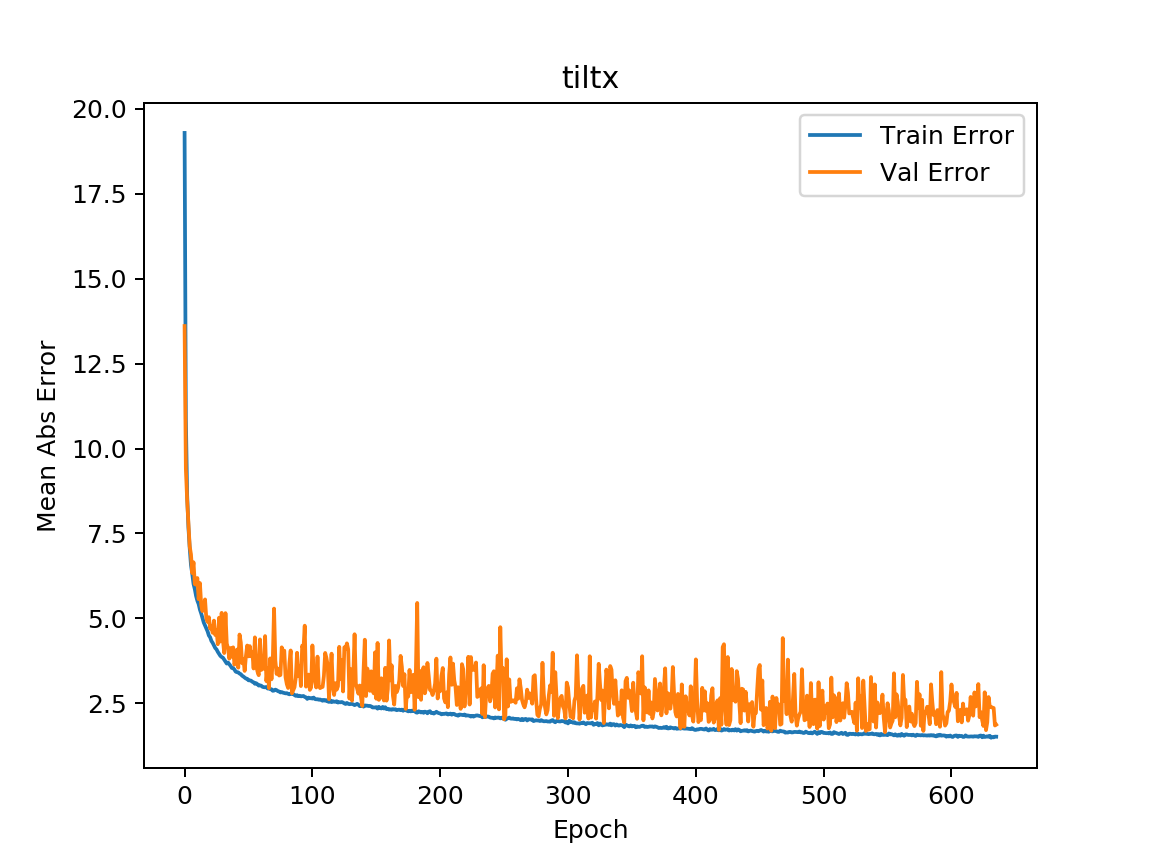

<IPython.core.display.Javascript object>


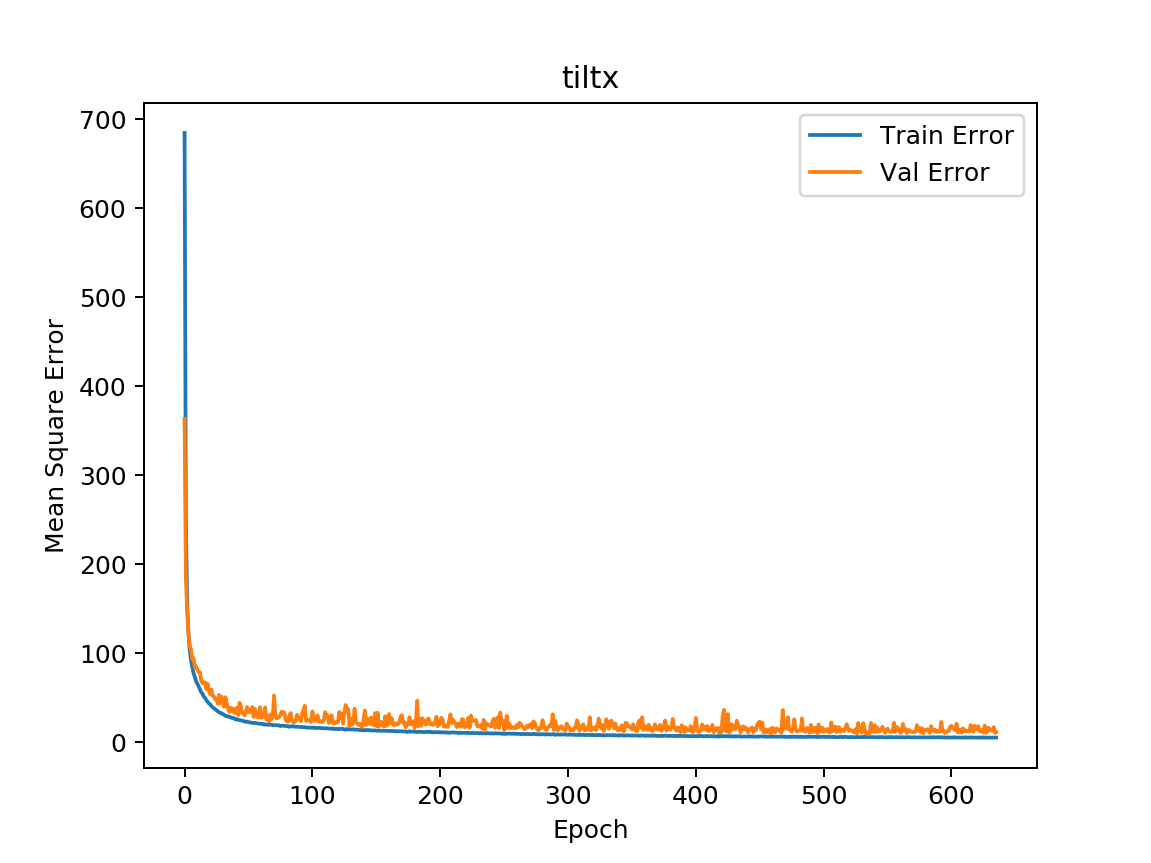

In [170]:
def plot_history(history, label=None):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.legend()
    if label is not None:
        plt.title(label)

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.legend()
    if label is not None:
        plt.title(label)
    plt.savefig(f"{label}_train.pdf")
    plt.show()


plot_history(histories['tiltx'], label="tiltx")

In [161]:
def show_results(label):
    loss, mae, mse = models[label].evaluate(normed_test_data, test_labels[label], verbose=0)

    print("Testing set Mean Abs Error: {:5.2f} um".format(mae))
    print("Testing set RMS: {:5.2f} um".format(np.sqrt(mse)))

    test_predictions = models[label].predict(normed_test_data).flatten()

    plt.scatter(test_labels[label], test_predictions)
    plt.xlabel('True Values [um]')
    plt.ylabel('Predictions [um]')
    plt.axis('equal')
    plt.axis('square')
    plt.plot([-2000, 2000], [-2000, 2000])
    plt.show()

Testing set Mean Abs Error: 13.77 um
Testing set RMS: 24.13 um


<IPython.core.display.Javascript object>


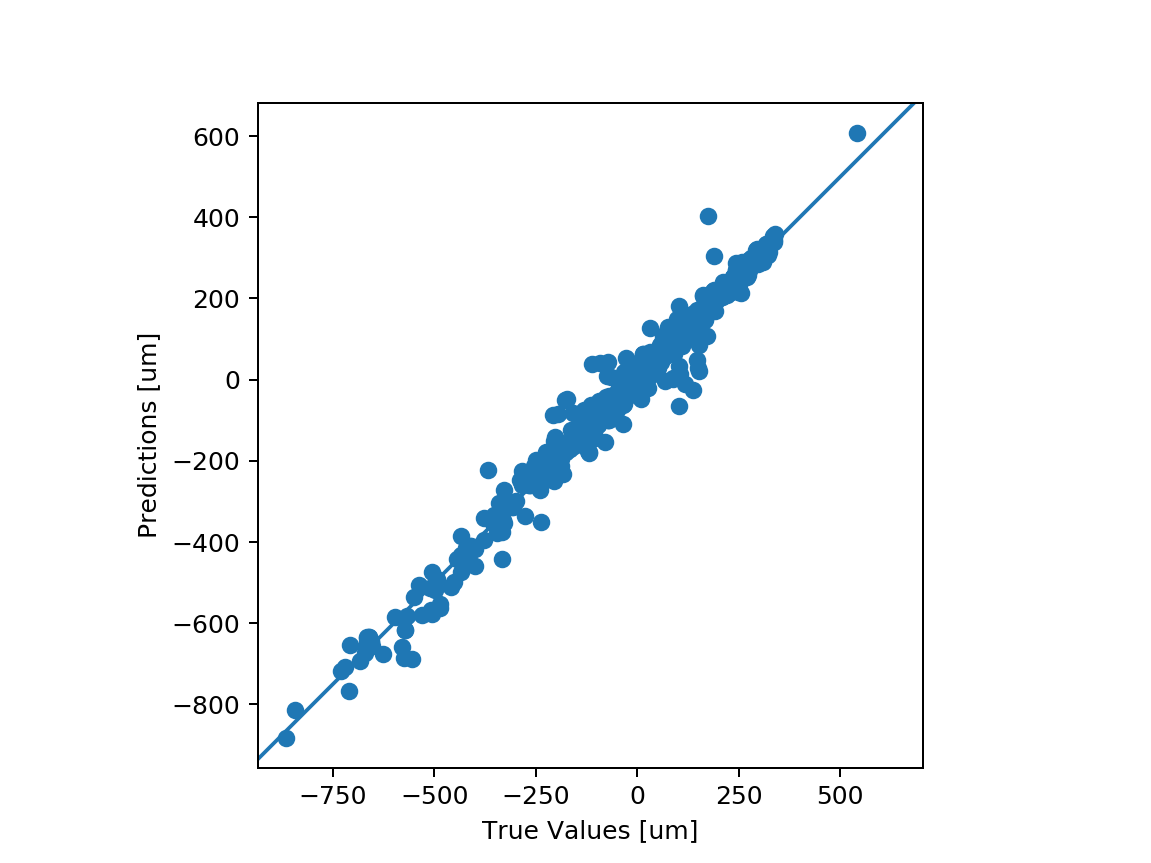

In [169]:
show_results('focus')

In [103]:
diff = test_labels['focus'] - test_predictions
diff.idxmax(), diff.idxmin()

(6871, 62)

In [105]:
test_dataset.loc[62]

az         130.976158
chamt        6.525000
el          39.533367
osst        11.000000
outt         5.800000
mjd      58500.119016
hour         2.000000
f9           0.000000
f5           0.000000
mmirs        1.000000
bino         0.000000
Name: 62, dtype: float64

In [106]:
diff.min(), diff.max()

(-210.50452937254522, 314.3279199884587)

In [65]:
test_dataset.loc[3125]

az          80.680000
chamt        0.100000
el          56.180000
osst         0.550000
outt         1.100000
mjd      58539.459502
hour        11.000000
f9           0.000000
f5           1.000000
mmirs        0.000000
bino         0.000000
Name: 3125, dtype: float64

In [164]:
for l in labels:
    models[l].save(f"{l}_model.h5")

In [142]:
m = keras.models.load_model("/Users/tim/MMT/HALcoll/halcoll/data/tiltx_model.h5")

In [143]:
m.evaluate(normed_test_data, test_labels['tiltx'])

1411/1411 [==============================] - 0s 208us/sample - loss: 23.9584 - mean_absolute_error: 2.9958 - mean_squared_error: 23.9584


[23.958368483204776, 2.9957743, 23.958368]

In [144]:
np.sqrt(24)

4.898979485566356